In [427]:
import sys
import os

import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from matplotlib import pylab as plt
from scipy.spatial.distance import squareform
from scipy import stats
from numba import njit
from numpy import save
from numpy import load
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale
sns.set_style('ticks')
sns.set_context('talk')

# Read HDF5 file

In [428]:
# Mouse = 163
# Plane = 1

saveDataFramePath = '/Volumes/WD_BLACK/Simon/20210816_phase2_passive/668/Analysis/Plane_2'

DataFramePath ='/Volumes/WD_BLACK/Simon/20210816_phase2_passive/668/Analysis/Plane_2/Master_DataFrame_Plane_2_668_Day0_passive.h5'
# DataFramePath = '/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_1/Mouse#%d/Analysis/Plane_%d/Master_DataFrame_Plane_%d_%d.h5' %(Mouse, Plane, Plane, Mouse)

DF= pd.read_hdf(DataFramePath, key='DF', mode='r')

print ('DF fields:\n')
print (list(DF.columns))
DF

DF fields:

['xmlFrameID', 'suite2pFrameID', 'framePeriod', 'frameRate', 'relativeTime', 'absoluteTime', 'cellID', 'F', 'Fneu', 'F_red', 'Fneu_red', 'deconv', 'odorPos', 'odorID', 'trialID', 'cellProbBinary', 'cellProbRaw', 'Fadj', 'Fadj_red']


xmlFrameID suite2pFrameID  framePeriod  frameRate  relativeTime  \
0              1              0     0.221194   4.520925      0.147462   
1              2              1     0.221194   4.520925      0.368656   
2              3              2     0.221194   4.520925      0.589850   
3              4              3     0.221194   4.520925      0.811044   
4              5              4     0.221194   4.520925      1.032237   
...          ...            ...          ...        ...           ...   
9995        9996             95     0.221194   4.520918     21.160895   
9996        9997             96     0.221194   4.520918     21.382089   
9997        9998             97     0.221194   4.520918     21.603283   
9998        9999             98     0.221194   4.520918     21.824478   
9999       10000             99     0.221194   4.520918     22.045672   

      absoluteTime  cellID           F        Fneu       F_red    Fneu_red  \
0        11.770462       0  740.094116  353.484436  131.798264  209.979233   
1        11.991656       0  729.219360  339.579010  252.612549  239.204147   
2        12.212850       0  698.440674  342.265289  316.134277  286.236450   
3        12.434044       0  761.142273  331.516724  282.267059  206.116501   
4        12.655237       0  700.194275  336.538635  302.705414  256.758942   
...            ...     ...         ...         ...         ...         ...   
9995   3200.821895      51  161.036957  151.483444  189.786499  107.641304   
9996   3201.043089      51  162.020905  170.888199  188.443817  113.707558   
9997   3201.264283      51  157.415802  163.856110   82.935196  111.178574   
9998   3201.485478      51  174.212967  163.340576   81.991203  105.979294   
9999   3201.706672      51  150.031631  164.725677   67.499214  142.756729   

          deconv odorPos odorID trialID  cellProbBinary  cellProbRaw  \
0       0.000000       0      6       0             1.0     0.936678   
1      44.836506       0      6       0             1.0     0.936678   
2      12.952067       0      6       0             1.0     0.936678   
3     100.985992       0      6       0             1.0     0.936678   
4       0.000000       0      6       0             1.0     0.936678   
...          ...     ...    ...     ...             ...          ...   
9995    0.000000       4      4      19             0.0     0.135402   
9996    0.000000       4      4      19             0.0     0.135402   
9997    0.000000       4      4      19             0.0     0.135402   
9998    3.836368       4      4      19             0.0     0.135402   
9999    0.000000       4      4      19             0.0     0.135402   

            Fadj    Fadj_red  
0     492.655011  -15.187199  
1     491.514053   85.169646  
2     458.854971  115.768762  
3     529.080566  137.985509  
4     464.617230  122.974155  
...          ...         ...  
9995   54.998546  114.437586  
9996   42.399165  108.848527  
9997   42.716525    5.110194  
9998   59.874564    7.805698  
9999   34.723657  -32.430496  

[520000 rows x 19 columns]

In [429]:
# Resort based on odor Identity from 1-10. 
DFsorted = DF.sort_values(['cellID', 'trialID', 'odorID', 'suite2pFrameID'])

# alternatively sort by acquisition order:
# DFsorted = DF.sort_values(['cellID', 'trialID', 'odorPos', 'suite2pFrameID'])

In [430]:
# define some arguments for later:
numCells = DF["cellID"].iloc[-1]+1
numFramesOdorTrial = 100
numOdors = 5
numTrials = 20
numOdorTrials = 100

# Create 4D numpy array as cells x trials x stimuli x time

In [431]:
#Let's pull data from this DF into an array whose dimensions will be (numCells, numTrials, numOdors, numFrames)
# the signal for each cell (i.e. F, Fneu, Fadj, deconv) is a 1-d trace... a flattened version of numTrials, numOdors, numFramesOdorTrial since in the DF above, frame changes fastest, then odorPos, then trialID
# Note, that traces have been reshuffled now according to odor identity... now sequenced 1-10.
from sklearn.preprocessing import scale
numCells = DF["cellID"].iloc[-1]+1

DataArray_Fadj = []
DataArray_Fadj_Fluo = []
for cell in range(numCells):
    Fadj_trace = DFsorted.loc[DFsorted.cellID==cell,'Fadj'].values
    
    
    # scale each cell's signal in its entirety
    Fadj_trace_scale=scale(Fadj_trace)

    DataArray_Fadj.append(Fadj_trace_scale.reshape(numTrials,numOdors,numFramesOdorTrial)[None])
    DataArray_Fadj_Fluo.append(Fadj_trace.reshape(numTrials,numOdors,numFramesOdorTrial)[None])
DataArray_Fadj = np.concatenate(DataArray_Fadj,0)
DataArray_Fadj_Fluo = np.concatenate(DataArray_Fadj_Fluo,0)

print (DataArray_Fadj.shape)

(52, 20, 5, 100)


# Do the same for tdTomato cells - Fluo only, no scale

In [432]:
#DO THE SAME FOR RED SIGNAL - ONLY FLUO NO SCALE
DataArray_Fadj_Fluo_red = []
for cell in range(numCells):
    Fadj_trace_red = DFsorted.loc[DFsorted.cellID==cell,'Fadj_red'].values
    DataArray_Fadj_Fluo_red.append(Fadj_trace_red.reshape(numTrials,numOdors,numFramesOdorTrial)[None])

DataArray_Fadj_Fluo_red = np.concatenate(DataArray_Fadj_Fluo_red,0)

print (DataArray_Fadj_Fluo_red.shape)

(52, 20, 5, 100)


# Filter array for true positive cells, both Green/Red (from Suite2P)

In [433]:
#get cellIDs that satisfy this criterion
cellsToKeep = DFsorted.loc[DFsorted.cellProbBinary>0.5].cellID.unique()

filteredDataArray = DataArray_Fadj[cellsToKeep,:,:,:]
filteredDataArray_Fluo = DataArray_Fadj_Fluo[cellsToKeep,:,:,:]
filteredDataArray_Fluo_red = DataArray_Fadj_Fluo_red[cellsToKeep,:,:,:]
print (filteredDataArray.shape)

cellsToKeepTrue = np.count_nonzero(cellsToKeep, axis=0)
cellsToKeepTrue = cellsToKeepTrue+1
cellsToKeepTrue

(43, 20, 5, 100)


43

# Calculate Pearson correlation coefficient between GCaMP and tdTomato signal

In [434]:
#np.range to check  

result_array_correlation = np.zeros((cellsToKeepTrue,numOdors,numTrials))
for cell in range(cellsToKeepTrue):
    for odor in range(numOdors):
        for trial in range(numTrials):
            result_array_correlation[cell,odor,trial] = stats.pearsonr(filteredDataArray_Fluo[cell,trial,odor,:],filteredDataArray_Fluo_red[cell,trial,odor,:])[0] #0 = r, 1= p-value
result_array_correlation.shape

(43, 5, 20)

In [435]:
# Mean of r accross trials, then stimuli 

result_array_correlation1 = result_array_correlation.mean(2)
result_array_correlation2 = result_array_correlation1.mean(1)
result_array_correlation2.shape

(43,)

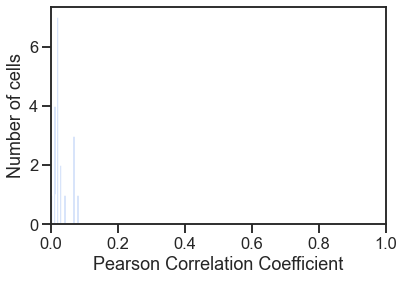

In [436]:
CorrThrslhd = 0.50 #choose threshold

Pll=plt.hist(result_array_correlation2, bins = 30, color='cornflowerblue')
plt.ylabel('Number of cells')
plt.xlabel('Pearson Correlation Coefficient')
# plt.axvline(CorrThrslhd, color= 'firebrick', alpha = 0.5)
plt.xlim(0,1)
path10 = os.path.join(saveDataFramePath, "Correlation_Coeff_Plane_1.png")
plt.savefig(path10, transparent = True, dpi = 300, bbox_inches='tight')

# Calculate Fluorescence distribution of GCaMP and tdTomato - Non scaled arrays

In [437]:
def GetFluoMeanValueDistribution (array, lthresh, hthresh, Fluorophore):
    cellsmean= array.mean(1)
    cellsmean= cellsmean[...,lthresh:hthresh]
    cellsmean= cellsmean.mean(2)
    cellsmean= cellsmean.mean(1)
    cellsmean.shape

    Pm=plt.hist(cellsmean, bins = 40, color = Fluorophore)
    #plt.title(title)
    plt.xlabel('Fluoresence value')
    plt.ylabel('number of cells')

# Same but normalize signal

Text(0, 0.5, 'number of cells')

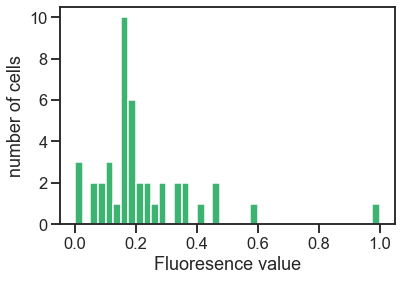

In [438]:
FluoDistr= filteredDataArray_Fluo.mean(1)
FluoDistr= FluoDistr[...,0:45]
FluoDistr= FluoDistr.mean(2)
FluoDistr= FluoDistr.mean(1)
FluoDistr.shape

FluoDistr = FluoDistr[FluoDistr >= 0]
FluoDistrNorm = preprocessing.minmax_scale(FluoDistr, feature_range=(0, 1),axis=0, copy=True)

Pm=plt.hist(FluoDistrNorm, bins = 40, color = 'mediumseagreen')
plt.xlabel('Fluoresence value')
plt.ylabel('number of cells')

# path10 = os.path.join(saveDataFramePath, "Distribution_GCaMP_baseline_Plane_1.png")
# plt.savefig(path10, transparent = True, dpi = 300, bbox_inches='tight')

Text(0, 0.5, 'number of cells')

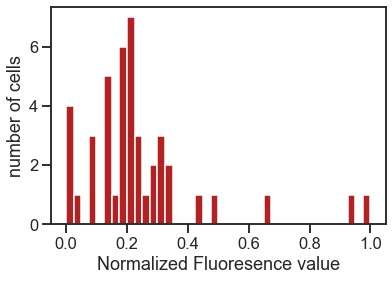

In [439]:
RedThrslhdNorm = 0.53

FluoDistr= filteredDataArray_Fluo_red.mean(1)
FluoDistr= FluoDistr[...,0:45]
FluoDistr= FluoDistr.mean(2)
FluoDistr= FluoDistr.mean(1)
FluoDistr.shape

# FluoDistr = FluoDistr[FluoDistr >= 0]
FluoDistrNorm = preprocessing.minmax_scale(FluoDistr, feature_range=(0, 1),axis=0, copy=True)

Pm=plt.hist(FluoDistrNorm, bins = 40, color = 'firebrick')
#plt.axvline(RedThrslhdNorm, color = 'firebrick', alpha = 0.5)
plt.xlabel('Normalized Fluoresence value')
plt.ylabel('number of cells')

# path12 = os.path.join(saveDataFramePath, "Distribution_tdTomato_baseline_Plane_1.png")
# plt.savefig(path12, transparent = True, dpi = 300, bbox_inches='tight')

In [440]:
    # sort tdTom fluo values from lowest to highest 
    maxidx = []
    maxidx.append(np.argsort(FluoDistr)[0:])
    maxidx

[array([ 4, 19, 38, 20, 30, 26, 33, 25, 12, 16, 10, 40,  8, 17,  5,  1, 24,
        14, 39, 15, 29,  9, 37, 21, 28, 22,  3, 13, 27, 35, 23,  2, 31,  0,
        42,  7, 36, 11, 41, 32, 34,  6, 18])]

In [441]:
    # sort tdTom fluo values from lowest to highest 
    maxidx = []
    maxidx.append(np.argsort(result_array_correlation2)[0:])
    maxidx

[array([38, 37, 33, 40, 42, 14, 27, 34, 36, 15, 10, 39, 25,  9, 32,  7, 17,
        29, 12, 26, 20,  5, 41, 35, 19,  4, 13, 22, 28, 31, 23, 16,  8, 24,
        18, 11,  0, 30, 21,  1,  3,  6,  2])]

In [442]:
fig, ax = plt.subplots(1,1, figsize = (10,5))
plt.plot(filteredDataArray_Fluo[0].flatten(), color='mediumseagreen')
plt.plot(filteredDataArray_Fluo_red[0].flatten(), color='firebrick', alpha=0.7)
sns.despine()
plt.xlabel('Time (frames)')
plt.ylabel('Fluoresence value')
# path10 = os.path.join(saveDataFramePath, "Cell16_Plane0_highCorr.png")
# plt.savefig(path10, transparent = True, dpi = 300, bbox_inches='tight')

Text(0, 0.5, 'Fluoresence value')

In [443]:
ax = filteredDataArray_Fluo[100,1,2,:]
ayy = filteredDataArray_Fluo_red[100,1,2,:]
ax.shape

plt.plot(ayy, color='firebrick')
plt.plot(ax, color= 'mediumseagreen')
# path10 = os.path.join(saveDataFramePath, "Cell100_Plane0_lowCorr_1trial.png")
# plt.savefig(path10, transparent = True, dpi = 300, bbox_inches='tight')

IndexError: index 100 is out of bounds for axis 0 with size 43

# Scatter plot normalized tdTomato along with r

In [ ]:
result_array_correlation2.shape

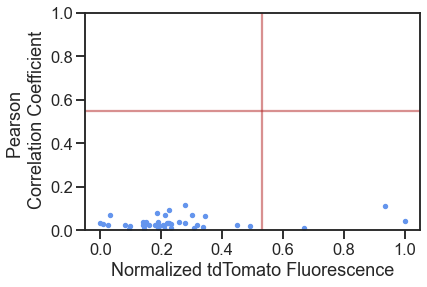

In [444]:
#cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
plt.scatter(x=FluoDistrNorm, y=result_array_correlation2, c='cornflowerblue', s=15)
plt.ylabel('Pearson \n Correlation Coefficient')
plt.xlabel('Normalized tdTomato Fluorescence')
plt.ylim(0,1)
plt.axvline(RedThrslhdNorm, color = 'firebrick', alpha = 0.5)
plt.axhline(0.55, color = 'firebrick', alpha = 0.5)

# path12 = os.path.join(saveDataFramePath, "NormFluo_Corr_Plane_0.png")
# plt.savefig(path12, transparent = True, dpi = 300, bbox_inches='tight')

In [445]:
GetFluoMeanValueDistribution(array=filteredDataArray_Fluo_red,lthresh=0, hthresh=45, Fluorophore="firebrick")
plt.xlim(0)
plt.axvline(200, color = 'firebrick', alpha = 0.5)

# Get tdTomato positive cells list!

In [446]:
# Necessary to do it on all cells (aka with false positives)
Redcellsmean= DataArray_Fadj_Fluo_red.mean(1)
Redcellsmean= Redcellsmean[...,0:45]
Redcellsmean= Redcellsmean.mean(2)
Redcellsmean= Redcellsmean.mean(1)

In [447]:
RedCellId = []
RedCellProb = []
for cell in range (numCells):
    RedCellId1= DF.loc [DF.cellID==cell, 'cellID'].values
    RedCellProb1= DF.loc [DF.cellID==cell, 'cellProbBinary'].values
    RedCellId.append(RedCellId1.reshape(numTrials,numOdors,numFramesOdorTrial)[None])
    RedCellProb.append(RedCellProb1.reshape(numTrials,numOdors,numFramesOdorTrial)[None])

RedCellId = np.concatenate(RedCellId,0)
RedCellProb = np.concatenate(RedCellProb,0)

RedCellId = RedCellId[:,0,0,0]
RedCellProb = RedCellProb[:,0,0,0]

print(f'4D matrices are the same size: {RedCellId.shape==Redcellsmean.shape}')

4D matrices are the same size: True


In [448]:
#np.range to check  

result_array_correlationforRED = np.zeros((numCells,numOdors,numTrials))
for cell in range(numCells):
    for odor in range(numOdors):
        for trial in range(numTrials):
            result_array_correlationforRED[cell,odor,trial] = stats.pearsonr(DataArray_Fadj_Fluo[cell,trial,odor,:],DataArray_Fadj_Fluo_red[cell,trial,odor,:])[0] #0 = r, 1= p-value
result_array_correlationforRED.shape

result_array_correlationforRED1 = result_array_correlationforRED.mean(2)
result_array_correlationforRED2 = result_array_correlationforRED1.mean(1)
result_array_correlationforRED2.shape

(52,)

In [449]:
RedCellList = pd.DataFrame(np.vstack((RedCellId[:], RedCellProb[:], Redcellsmean[:], result_array_correlationforRED2[:]))).T

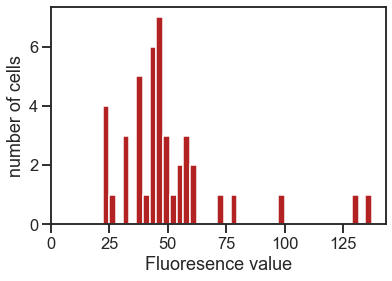

In [450]:
GetFluoMeanValueDistribution(array=filteredDataArray_Fluo_red,lthresh=0, hthresh=45, Fluorophore="firebrick")
plt.xlim(0)
plt.axvline(200, color = 'firebrick', alpha = 0.5)

In [451]:
# Put Fluorescence intensity threshold to select true positive tdTomato cells
RedThrslhd = 80

RedCellListFinal = RedCellList[RedCellList[1] == 1.0]
RedCellListFinal = RedCellListFinal[RedCellListFinal[2] >= RedThrslhd]
RedCellListFinal = RedCellListFinal[RedCellListFinal[3] <= CorrThrslhd]
RedCellListFinal = RedCellListFinal.rename({0: 'cellID', 1: 'GreencellProb', 2: 'RedcellMeanFluo', 3:'CorrelationGreenRed'}, axis=1)
RedCellListFinal

cellID  GreencellProb  RedcellMeanFluo  CorrelationGreenRed
6      6.0            1.0       129.977748             0.112442
19    19.0            1.0       137.474842             0.041167
37    37.0            1.0        99.441148             0.012372

# Create 4D numpy array with only tdTomato cells

In [452]:
# Create list of Redcells to keep from above
RedcellsToKeep = RedCellListFinal['cellID']
RedcellsToKeep = RedcellsToKeep.to_numpy()
RedcellsToKeep = RedcellsToKeep.astype(int)

In [453]:
DataArray_Red = DataArray_Fadj[RedcellsToKeep,:,:,:]
DataArray_Red.shape

(3, 20, 5, 100)

# Drop Red cells to get Green only

In [454]:
GreenCellListFinal = RedCellList[RedCellList[1] == 1.0]
GreenCellListFinal = GreenCellListFinal[GreenCellListFinal[2] < RedThrslhd]
GreenCellListFinal = GreenCellListFinal.rename({0: 'cellID', 1: 'GreencellProb', 2: 'RedcellMeanFluo'}, axis=1)

In [455]:
GreencellsToKeep = GreenCellListFinal['cellID']
GreencellsToKeep = GreencellsToKeep.to_numpy()
GreencellsToKeep = GreencellsToKeep.astype(int)

In [456]:
DataArray_Green = DataArray_Fadj[GreencellsToKeep,:,:,:]
DataArray_Green.shape

(40, 20, 5, 100)

# get list of cells for each quadrants

In [457]:
RedCellListFinalQ1 = RedCellList[RedCellList[1] == 1.0]
RedCellListFinalQ1 = RedCellListFinalQ1[RedCellListFinalQ1[2] <= RedThrslhd]
RedCellListFinalQ1 = RedCellListFinalQ1[RedCellListFinalQ1[3] >= CorrThrslhd]
RedCellListFinalQ1 = RedCellListFinalQ1.rename({0: 'cellID', 1: 'GreencellProb', 2: 'RedcellMeanFluo', 3:'CorrelationGreenRed'}, axis=1)

# Create list of Redcells to keep from above
RedCellListFinalQ1 = RedCellListFinalQ1['cellID']
RedCellListFinalQ1 = RedCellListFinalQ1.to_numpy()
RedCellListFinalQ1 = RedCellListFinalQ1.astype(int)

RedCellListFinalQ2 = RedCellList[RedCellList[1] == 1.0]
RedCellListFinalQ2 = RedCellListFinalQ2[RedCellListFinalQ2[2] >= RedThrslhd]
RedCellListFinalQ2 = RedCellListFinalQ2[RedCellListFinalQ2[3] >= CorrThrslhd]
RedCellListFinalQ2 = RedCellListFinalQ2.rename({0: 'cellID', 1: 'GreencellProb', 2: 'RedcellMeanFluo', 3:'CorrelationGreenRed'}, axis=1)

# Create list of Redcells to keep from above
RedCellListFinalQ2 = RedCellListFinalQ2['cellID']
RedCellListFinalQ2 = RedCellListFinalQ2.to_numpy()
RedCellListFinalQ2 = RedCellListFinalQ2.astype(int)

RedCellListFinalQ3 = RedCellList[RedCellList[1] == 1.0]
RedCellListFinalQ3 = RedCellListFinalQ3[RedCellListFinalQ3[2] <= RedThrslhd]
RedCellListFinalQ3 = RedCellListFinalQ3[RedCellListFinalQ3[3] <= CorrThrslhd]
RedCellListFinalQ3 = RedCellListFinalQ3.rename({0: 'cellID', 1: 'GreencellProb', 2: 'RedcellMeanFluo', 3:'CorrelationGreenRed'}, axis=1)

# Create list of Redcells to keep from above
RedCellListFinalQ3 = RedCellListFinalQ3['cellID']
RedCellListFinalQ3 = RedCellListFinalQ3.to_numpy()
RedCellListFinalQ3 = RedCellListFinalQ3.astype(int)

RedCellListFinalQ4 = RedCellList[RedCellList[1] == 1.0]
RedCellListFinalQ4 = RedCellListFinalQ4[RedCellListFinalQ4[2] >= RedThrslhd]
RedCellListFinalQ4 = RedCellListFinalQ4[RedCellListFinalQ4[3] <= CorrThrslhd]
RedCellListFinalQ4 = RedCellListFinalQ4.rename({0: 'cellID', 1: 'GreencellProb', 2: 'RedcellMeanFluo', 3:'CorrelationGreenRed'}, axis=1)

# Create list of Redcells to keep from above
RedCellListFinalQ4 = RedCellListFinalQ4['cellID']
RedCellListFinalQ4 = RedCellListFinalQ4.to_numpy()
RedCellListFinalQ4 = RedCellListFinalQ4.astype(int)

In [458]:
CorrThrslhd = 0.5

In [459]:
# Calculate mean value for all trials for each stimulus
DataArray_Fadj_Fluo_trialmean = DataArray_Fadj_Fluo.mean(1)
DataArray_Fadj_Fluo_red_trialmean = DataArray_Fadj_Fluo_red.mean(1)

In [460]:
RedCellListFinalQ1

array([], dtype=int64)

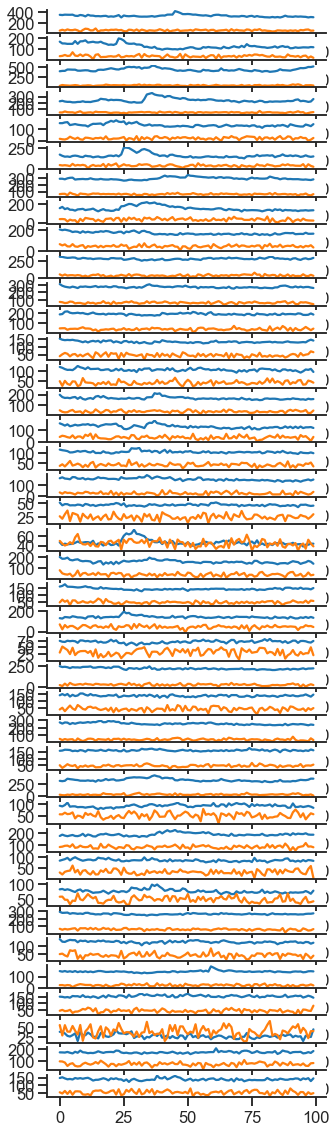

In [461]:
FOLDER_PATH = '/Users/sdaste/Desktop/DATA/OB_dataset_Analysis/Odor_set_1/Mouse#163/Analysis/Plane_1'
odorid = 3
quadrantNum = 3

fig, ax = plt.subplots(len(RedCellListFinalQ3),1, figsize = (5,20)); #ax = ax.ravel()
for ind_ax, cell in enumerate(RedCellListFinalQ3): 
    ax[ind_ax].plot(DataArray_Fadj_Fluo_trialmean[cell,odorid,:])
    ax[ind_ax].plot(DataArray_Fadj_Fluo_red_trialmean[cell,odorid,:])
sns.despine()

# path42 = os.path.join(FOLDER_PATH, "Mean_Traces_odor%d_Q%d.png") %(odorid, quadrantNum)
# plt.savefig(path42, transparent = True, dpi = 300, bbox_inches='tight')

# Final matrices to work with - cells x trials x stimuli x time

In [462]:
filteredDataArraypath = os.path.join(saveDataFramePath, "filteredDataArray.npy")
DataArray_Redpath = os.path.join(saveDataFramePath, "DataArray_Red.npy")
DataArray_Greenpath = os.path.join(saveDataFramePath, "DataArray_Green.npy")
RedCellListSavepath = os.path.join(saveDataFramePath, "RedCellList.npy")

In [463]:
#All Cells 
                            #filteredDataArray
save(file = filteredDataArraypath, arr= filteredDataArray)

#Only Red cells
                            #DataArray_Red
save(file = DataArray_Redpath, arr= DataArray_Red)

#Only Green non-Red cells
                            #DataArray_Green
save(file = DataArray_Greenpath, arr= DataArray_Green)

#List of tdTomato cells
                            #RedCellList
save(file = RedCellListSavepath, arr= RedCellListFinal)